In [31]:
import numpy as np

img = np.load("/home/nics/Work/sp-sold2/assets/img/img_origin.npy")
warped_img = np.load("/home/nics/Work/sp-sold2/assets/img/img_warped.npy")
pts = np.load("/home/nics/Work/sp-sold2/assets/img/points_origin.npy")
warped_pts = np.load("/home/nics/Work/sp-sold2/assets/img/points_warped.npy")
h = np.load("/home/nics/Work/sp-sold2/assets/img/homo.npy")
from utils.superpoint import SuperPointFrontend
from skimage import color 
# print(warped_img.shape)
weights_path = "/home/nics/Work/SuperPointPretrainedNetwork/superpoint_v1.pth"
nms_dist = 4
conf_thresh = 0.015
nn_thresh = 0.7
cuda = True
fe = SuperPointFrontend(weights_path=weights_path,
                          nms_dist=nms_dist,
                          conf_thresh=conf_thresh,
                          nn_thresh=nn_thresh,
                          cuda=cuda)
grayim1 = color.rgb2gray(img).astype(np.float32)
grayim2 = warped_img
# print(grayim2.shape)
# print(grayim.shape)
pts1, desc1, _ = fe.run(grayim1)
pts2, desc2, _ = fe.run(grayim2)
print(pts2.shape, desc2.shape)

(3, 341) (1, 256, 64, 64)


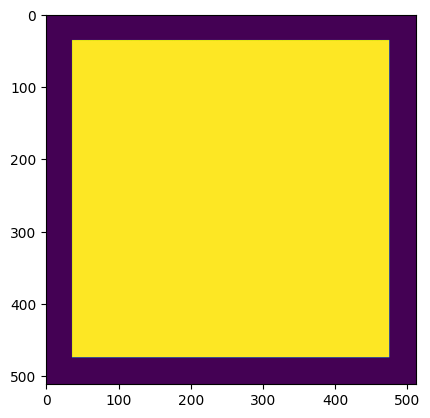

In [47]:
import matplotlib.pyplot as plt
img2 = np.load("/home/nics/Work/sp-sold2/assets/img/valid_mask2.npy")
plt.imshow(img2)


In [44]:
from sold2.misc.visualize_util import plot_images, plot_lines, plot_line_matches, plot_color_line_matches, plot_keypoints, plot_line_segments_from_segments

def plot_pts(pts_list, indices=[0]):
    fig = plt.gcf()
    ax = fig.axes
    # print(len(ax), max(indices))
    # assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, pts in zip(axes, pts_list):
        for i in range(pts.shape[1]):
            # print(pts[:,i])
            # p = pts[:, i]
            a.scatter(pts[0,i], pts[1,i], color="red", s=0.8)
valid_mask = np.load("/home/nics/Work/sp-sold2/assets/img/valid_mask.npy")
cells = np.load("/home/nics/Work/sp-sold2/assets/img/cells_warped.npy")
# print(valid_mask[300])
# mask_img = warped_img.copy()
# mask_img[valid_mask] = 255
# plt.imshow(valid_mask)
plot_images([valid_mask], ['valid_mask'])


ImportError: attempted relative import with no known parent package

In [32]:
margin_pos = 1.
margin_neg = 0.2
desc1 = desc1.transpose(0, 2, 3, 1)
print(desc1.shape)
# descriptors = descriptors.view((batch_size, Hc, Wc, 1, 1, -1))
desc2 = desc2.transpose(0,2,3,1)

(1, 64, 64, 256)


In [24]:

# descriptors_warped = descriptors_warped.view((batch_size, 1, 1, Hc, Wc, -1))
dot_product_desc = desc1 * desc2
dot_product_desc = dot_product_desc.sum(axis=-1)
print(dot_product_desc.shape)
pos_loss = margin_pos - dot_product_desc
neg_loss = dot_product_desc - margin_neg
positive_dist = np.maximum(pos_loss, 0)
negative_dist = np.maximum(neg_loss, 0)
# positive_dist = max(margin_pos - dot_product_desc, np.array(0.))
# positive_dist[positive_dist < 0] = 0
# negative_dist = max(dot_product_desc - margin_neg, np.array(0.))

(1, 64, 64)


In [27]:
np.min(positive_dist)

0.31603473

In [54]:
import torch
def warp_points(points, homographies, device='cpu'):
    """
    Warp a list of points with the given homography.

    Arguments:
        points: list of N points, shape (N, 2(x, y))).
        homography: batched or not (shapes (B, 3, 3) and (...) respectively).

    Returns: a Tensor of shape (N, 2) or (B, N, 2(x, y)) (depending on whether the homography
            is batched) containing the new coordinates of the warped points.

    """
    # expand points len to (x, y, 1)
    no_batches = len(homographies.shape) == 2
    homographies = homographies.unsqueeze(0) if no_batches else homographies
    # homographies = homographies.unsqueeze(0) if len(homographies.shape) == 2 else homographies
    batch_size = homographies.shape[0]
    points = torch.cat((points.float(), torch.ones((points.shape[0], 1)).to(device)), dim=1)
    points = points.to(device)
    homographies = homographies.view(batch_size*3,3).float()
    # warped_points = homographies*points
    # points = points.double()
    warped_points = homographies@points.transpose(0,1)
    # warped_points = np.tensordot(homographies, points.transpose(), axes=([2], [0]))
    # normalize the points
    warped_points = warped_points.view([batch_size, 3, -1])
    warped_points = warped_points.transpose(2, 1)
    warped_points = warped_points[:, :, :2] / warped_points[:, :, 2:]
    return warped_points[0,:,:] if no_batches else warped_points

def normPts(pts, shape):
    """
    normalize pts to [-1, 1]
    :param pts:
        tensor (y, x)
    :param shape:
        tensor shape (y, x)
    :return:
    """
    pts = pts/shape*2 - 1
    return pts

def denormPts(pts, shape):
    """
    denormalize pts back to H, W
    :param pts:
        tensor (y, x)
    :param shape:
        numpy (y, x)
    :return:
    """
    pts = (pts+1)*shape/2
    return pts
h = np.load("/home/nics/Work/sp-sold2/assets/img/homo.npy")

# put to gpu
device = "cuda"
homographies = torch.from_numpy(h).to(device)
# config
# from utils.utils import warp_points
lamda_d = 250 # 250
margin_pos = 1
margin_neg = 0.2
cell_size = 8
Hc = 64
Wc = 64
# batch_size, Hc, Wc = descriptors.shape[0], descriptors.shape[2], descriptors.shape[3]
#####
# H, W = Hc.numpy().astype(int) * cell_size, Wc.numpy().astype(int) * cell_size
H, W = Hc * cell_size, Wc * cell_size
#####
with torch.no_grad():
    # shape = torch.tensor(list(descriptors.shape[2:]))*torch.tensor([cell_size, cell_size]).type(torch.FloatTensor).to(device)
    shape = torch.tensor([H, W]).type(torch.FloatTensor).to(device)
    # compute the center pixel of every cell in the image

    coor_cells = torch.stack(torch.meshgrid(torch.arange(Hc), torch.arange(Wc)), dim=2)
    coor_cells = coor_cells.type(torch.FloatTensor).to(device)
    coor_cells = coor_cells * cell_size + cell_size // 2
    ## coord_cells is now a grid containing the coordinates of the Hc x Wc
    ## center pixels of the 8x8 cells of the image

    # coor_cells = coor_cells.view([-1, Hc, Wc, 1, 1, 2])
    coor_cells = coor_cells.view([-1, 1, 1, Hc, Wc, 2])  # be careful of the order
    # warped_coor_cells = warp_points(coor_cells.view([-1, 2]), homographies, device)
    warped_coor_cells = normPts(coor_cells.view([-1, 2]), shape)
    warped_coor_cells = torch.stack((warped_coor_cells[:,1], warped_coor_cells[:,0]), dim=1) # (y, x) to (x, y)
    warped_coor_cells = warp_points(warped_coor_cells, homographies, device)

    warped_coor_cells = torch.stack((warped_coor_cells[:, 1], warped_coor_cells[:, 0]), dim=1)  # (batch, x, y) to (batch, y, x)

    shape_cell = torch.tensor([H//cell_size, W//cell_size]).type(torch.FloatTensor).to(device)
    # warped_coor_mask = denormPts(warped_coor_cells, shape_cell)

    warped_coor_cells = denormPts(warped_coor_cells, shape)
    # warped_coor_cells = warped_coor_cells.view([-1, 1, 1, Hc, Wc, 2])
    warped_coor_cells = warped_coor_cells.view([-1, Hc, Wc, 1, 1, 2])
#     print("warped_coor_cells: ", warped_coor_cells.shape)
    # compute the pairwise distance
    cell_distances = coor_cells - warped_coor_cells
    cell_distances = torch.norm(cell_distances, dim=-1)
    ##### check
#     print("descriptor_dist: ", descriptor_dist)
    mask = cell_distances <= 8 # 0.5 # trick

    mask = mask.type(torch.FloatTensor).to(device)
mask
print(torch.min(cell_distances))
# compute the pairwise dot product between descriptors: d^t * d
# descriptors = descriptors.transpose(1, 2).transpose(2, 3)
# descriptors = descriptors.view((batch_size, Hc, Wc, 1, 1, -1))
# descriptors_warped = descriptors_warped.transpose(1, 2).transpose(2, 3)
# descriptors_warped = descriptors_warped.view((batch_size, 1, 1, Hc, Wc, -1))
# dot_product_desc = descriptors * descriptors_warped
# dot_product_desc = dot_product_desc.sum(dim=-1)

tensor(60296.5977, device='cuda:0')
